In [44]:
#import needed Python libraries
import numpy as np
import random
import pandas as pd
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

#graphics parameters of the notebook
# display graphs inline



# Make graphs prettier
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 400)
pd.set_option('plotting.matplotlib.register_converters', True)

# Make the fonts bigger
plt.rc('figure', figsize=(14, 7))
plt.rc('font', family='normal', weight='bold', size=15)

#inegrate data from 2009-2010 to 2018-2019 seasons from different files
data_18_19 = pd.read_csv("./data/2018_2019.csv", parse_dates=True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
data_17_18 = pd.read_csv("./data/2017_2018.csv", parse_dates=True)
data_16_17 = pd.read_csv("./data/2016_2017.csv", parse_dates=True)
data_15_16 = pd.read_csv("./data/2015_2016.csv", parse_dates=True)
data_14_15 = pd.read_csv("./data/2014_2015.csv", parse_dates=True)
data_13_14 = pd.read_csv("./data/2013_2014.csv", parse_dates=True)
data_12_13 = pd.read_csv("./data/2012_2013.csv", parse_dates=True)
data_11_12 = pd.read_csv("./data/2011_2012.csv", parse_dates=True)
data_10_11 = pd.read_csv("./data/2010_2011.csv", parse_dates=True)
data_09_10 = pd.read_csv("./data/2009_2010.csv", parse_dates=True)
data_08_09 = pd.read_csv("./data/2008_2009.csv", parse_dates=True)

#test about data consistency for all files
for df in [data_18_19, data_17_18, data_16_17, data_15_16, data_14_15, data_13_14, data_12_13, data_11_12, data_10_11, data_09_10, data_08_09]:
    print("Number of df columns : " + str(len(data_18_19.columns)))

#integrate data in a single df
raw_data = pd.concat([data_18_19, data_17_18, data_16_17, data_15_16, data_14_15, data_13_14, data_12_13, data_11_12, data_10_11, data_09_10, data_08_09])

print(raw_data)


Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
    17Div  AC  AF  AR  AS  AST  AY  ...   SJH    VCA    VCD    VCH    WHA    WHD    WHH
0      E0   5   8   0  13    4   1  ...   NaN   7.00   4.00   1.57   6.00   3.80   1.57
1      E0   4   9   0  10    1   1  ...   NaN   4.75   3.60   1.87   4.00   3.50   1.91
2      E0   5  11   0  10    9   2  ...   NaN   3.00   3.40   2.50   2.80   3.30   2.45
3      E0   5   8   0  13    4   1  ...   NaN   1.62   4.00   6.50   1.57   3.90   5.80
4      E0   5  12   0  15    5   2  ...   NaN   2.10   3.40   3.90   2.05   3.20   3.80
5      E0   2  16   0   6    0   2  ...   NaN   3.40   3.20   2.40   3.30   3.00   2.38
6      E0   6   7   1   6    5   1  ...   NaN   3.30   3.30   2.38   3.20   3.20   2.30
7      E0 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [45]:
# for maipulation
#Select useful features for data visualization and analysis purposes

E0_data = raw_data[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HTAG"]]

#convert date format to YYYY-MM-DD classic format
E0_data.Date = E0_data.Date.map(lambda x : "20" + x[6:8] + "-" + x[3:5] + "-" + x[0:2])
print(E0_data.Date)
#sort data by date
E0_data.sort_values('Date', inplace=True)

#reset data indexes
E0_data = E0_data.reset_index(drop=True)

#create matchID column
E0_data['matchID'] = E0_data.index


#create season feature
E0_data['Season'] = 0
E0_data.Season = E0_data.Date.map(lambda x : int(x[0:4]) if int(x[5:7]) > 6 else int(x[0:4]) - 1)

#null values test
E0_data.isnull().any()


#create teams list
teams = E0_data['HomeTeam'].unique()
print(teams)

#create seasons list
seasons = np.sort(E0_data['Season'].unique())
print(seasons)

#match day feature construction for HomeTeam and AwayTeam (1st match of a season --> 1, last --> 38 because 20 team play by season)
E0_HT_grpby = E0_data.groupby('HomeTeam')[['Date']]
E0_AT_grpby = E0_data.groupby('AwayTeam')[['Date']]

def fxyH(row):
    x = row['HomeTeam']
    y = row['Date']
    df1 = E0_HT_grpby.get_group(x)
    df2 = E0_AT_grpby.get_group(x)
    df1 = df1[df1['Date'] < y]
    df2 = df2[df2['Date'] < y]
    day = (1 + len(df1) + len(df2)) % 38
    return 38 if day == 0 else day 

def fxyA(row):
    x = row['AwayTeam']
    y = row['Date']
    df1 = E0_HT_grpby.get_group(x)
    df2 = E0_AT_grpby.get_group(x)
    df1 = df1[df1['Date'] < y]
    df2 = df2[df2['Date'] < y]
    day = (1 + len(df1) + len(df2)) % 38
    return 38 if day == 0 else day 

E0_data['HomeTeamDay'] = E0_data.apply(fxyH, axis=1)
E0_data['AwayTeamDay'] = E0_data.apply(fxyA, axis=1)

def resultConverter(A):
    if A == 'H':
        return 'W'
    elif A =='A':
        return 'L'
    else:
        return 'D'

def resultInverser(A):
    if A == 'W':
        return 'L'
    elif A == 'L':
        return 'W'
    else:
        return 'D'
def ordinalResultConverter(A):
    if A == 'W':
        return 1
    elif A == 'L':
        return 0
    else:
        return 0.5


    #make dummies variables for FTR (result of match), HW = Home Win, AW = Away Win, D = draw
E0_data['HW'] = E0_data.FTR.map(lambda x : 1 if x == 'H' else 0)
E0_data['AW'] = E0_data.FTR.map(lambda x : 1 if x == 'A' else 0)
E0_data['D']= E0_data.FTR.map(lambda x : 1 if x == 'D' else 0)

#make 2 different variable for the result of a match : 1 for the home team point of view, the other for the away team pt of view
E0_data['HR'] = E0_data.FTR.map(lambda x : resultConverter(x))
E0_data['AR'] = E0_data.HR.map(lambda x : resultInverser(x))

#make ordinal variable for the home team point of view result (1 = win, 0.5 = Draw, 0 = loss)
E0_data['ordinalHR'] = E0_data.HR.map(lambda x : ordinalResultConverter(x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


0      2018-08-10
1      2018-08-11
2      2018-08-11
3      2018-08-11
4      2018-08-11
5      2018-08-11
6      2018-08-11
7      2018-08-12
8      2018-08-12
9      2018-08-12
10     2018-08-18
11     2018-08-18
12     2018-08-18
13     2018-08-18
14     2018-08-18
15     2018-08-18
16     2018-08-19
17     2018-08-19
18     2018-08-19
19     2018-08-20
20     2018-08-25
21     2018-08-25
22     2018-08-25
23     2018-08-25
24     2018-08-25
25     2018-08-25
26     2018-08-26
27     2018-08-26
28     2018-08-26
29     2018-08-27
          ...    
350    2009-05-09
351    2009-05-09
352    2009-05-09
353    2009-05-09
354    2009-05-09
355    2009-05-09
356    2009-05-10
357    2009-05-10
358    2009-05-11
359    2009-05-13
360    2009-05-16
361    2009-05-16
362    2009-05-16
363    2009-05-16
364    2009-05-16
365    2009-05-16
366    2009-05-16
367    2009-05-17
368    2009-05-17
369    2009-05-18
370    2009-05-24
371    2009-05-24
372    2009-05-24
373    2009-05-24
374    200

In [46]:
# feature extraction 
grp_by_HT = E0_data.groupby('HomeTeam')
grp_by_AT = E0_data.groupby('AwayTeam')

#past performance features engineering
for team in teams:
    
    #we retrieve results series of the team
    teamHomeResults_s = grp_by_HT.get_group(team)['HR']
    teamAwayResults_s = grp_by_AT.get_group(team)['AR']
    #combine these 2 series and sort the obtained serie
    teamResults_s = pd.concat([teamHomeResults_s, teamAwayResults_s]).sort_index()

    #(i) compute k_last_HR and k_last_AR --> 6 features
    lag1TeamResults_d = teamResults_s.shift(1).to_dict()
    lag2TeamResults_d = teamResults_s.shift(2).to_dict()
    lag3TeamResults_d = teamResults_s.shift(3).to_dict()
    
    #k_last_HTR and k_last_ATR are just shifted versions of the results series
    E0_data.loc[teamHomeResults_s.index,'1_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag1TeamResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'2_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag2TeamResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'3_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag3TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'1_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag1TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'2_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag2TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'3_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag3TeamResults_d[x])
    
    #(ii) Compute k_last_HTRH and k_last ATAR --> 4 features
    #we need here to diferentiate home results and past results. Python dictionaries allows the program to access to
    #needed data faster than with a Pandas serie
    lag1TeamHomeResults_d = teamHomeResults_s.shift(1).to_dict()
    lag2TeamHomeResults_d = teamHomeResults_s.shift(2).to_dict()
    lag1TeamAwayResults_d = teamAwayResults_s.shift(1).to_dict()
    lag2TeamAwayResults_d = teamAwayResults_s.shift(2).to_dict()
    
    E0_data.loc[teamHomeResults_s.index,'1_last_HTHR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag1TeamHomeResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'2_last_HTHR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag2TeamHomeResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'1_last_ATAR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag1TeamAwayResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'2_last_ATAR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag2TeamAwayResults_d[x])
    
    #(iii) rates based features : we need to get only season specific results series (to avoid taking previous season results into season rates)
    for season in seasons:
        
        #retrieve season specific results serie (1 win serie, 1 draw serie the loss  will be computed thanks to
        #the 2 others)
        teamHomeResultsW_s = grp_by_HT.get_group(team)['HW']
        teamAwayResultsW_s = grp_by_AT.get_group(team)['AW']
        teamResultsW_s = pd.concat([teamHomeResultsW_s, teamAwayResultsW_s]).sort_index()

        teamHomeResultsD_s = grp_by_HT.get_group(team)['D']
        teamAwayResultsD_s = grp_by_AT.get_group(team)['D']
        teamResultsD_s = pd.concat([teamHomeResultsD_s, teamAwayResultsD_s]).sort_index()
        
        #(i) compute 7_HTW_rate, 12_HTW_rate, 7_HTD_rate, 12_HTD_rate, 7_ATW_rate, 12_ATW_rate, 7_ATD_rate, 12_ATD_rate --> 8 features
        win7TeamResultsW_d = teamResultsW_s.shift(1).rolling(window = 7, min_periods = 5).mean().to_dict()
        win12TeamResultsW_d = teamResultsW_s.shift(1).rolling(window = 12, min_periods = 8).mean().to_dict()
        win7TeamResultsD_d = teamResultsD_s.shift(1).rolling( window = 7, min_periods = 5).mean().to_dict()
        win12TeamResultsD_d = teamResultsD_s.shift(1).rolling( window = 12, min_periods = 8).mean().to_dict()
        
        E0_data.loc[teamHomeResultsW_s.index,'7_HTW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win7TeamResultsW_d[x])
        E0_data.loc[teamHomeResultsW_s.index,'12_HTW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win12TeamResultsW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'7_ATW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win7TeamResultsW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'12_ATW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win12TeamResultsW_d[x])
        
        E0_data.loc[teamHomeResultsD_s.index,'7_HTD_rate'] = E0_data.loc[teamHomeResultsD_s.index,:].index.map(lambda x : win7TeamResultsD_d[x])
        E0_data.loc[teamHomeResultsD_s.index,'12_HTD_rate'] = E0_data.loc[teamHomeResultsD_s.index,:].index.map(lambda x : win12TeamResultsD_d[x])
        E0_data.loc[teamAwayResultsD_s.index,'7_ATD_rate'] = E0_data.loc[teamAwayResultsD_s.index,:].index.map(lambda x : win7TeamResultsD_d[x])
        E0_data.loc[teamAwayResultsD_s.index,'12_ATD_rate'] = E0_data.loc[teamAwayResultsD_s.index,:].index.map(lambda x : win12TeamResultsD_d[x])

        #(ii) compute 5_HTHW_rate and 5_ATAW_rate
        win5TeamResultsHomeW_d = teamHomeResultsW_s.shift(1).rolling( window = 5, min_periods = 3).mean().to_dict()
        win5TeamResultsAwayW_d = teamAwayResultsW_s.shift(1).rolling( window = 5, min_periods = 3).mean().to_dict()
        E0_data.loc[teamHomeResultsW_s.index,'5_HTHW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win5TeamResultsHomeW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'5_ATAW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win5TeamResultsAwayW_d[x])

#compute missing features k_XTL_rate thanks to the k_XTW_rate and k_XTD_rate features
E0_data.loc[:,'7_HTL_rate'] = 1 - (E0_data['7_HTW_rate'] + E0_data['7_HTD_rate'])
E0_data.loc[:,'12_HTL_rate'] = 1 - (E0_data['7_HTW_rate'] + E0_data['7_HTD_rate'])
E0_data.loc[:,'7_ATL_rate'] = 1 - (E0_data['7_ATW_rate'] + E0_data['7_ATD_rate'])
E0_data.loc[:,'12_ATL_rate'] = 1 - (E0_data['7_ATW_rate'] + E0_data['7_ATD_rate'])

print(E0_data.loc[:,'12_ATL_rate'])

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
24           NaN
25           NaN
26           NaN
27           NaN
28           NaN
29           NaN
          ...   
4150    1.000000
4151    0.571429
4152    0.428571
4153    0.285714
4154    0.714286
4155    0.571429
4156    0.285714
4157    0.000000
4158    0.428571
4159    0.285714
4160    0.428571
4161    0.571429
4162    0.000000
4163    0.285714
4164    0.571429
4165    0.428571
4166    0.714286
4167    0.571429
4168    0.571429
4169    0.142857
4170    0.142857
4171    0.428571
4172    0.000000
4173    0.571429
4174    0.428571
4175    0.428571
4176    0.142857
4177    0.2857

In [47]:
#Elo ranking method parameters
k = 20.0
d = 400.0
c = 10.0

#Initialization of output containers
ELO_dict = dict()
gammaHT_dict = dict()
gammaAT_dict = dict()

#intermediate data containers initilization
latest_update_d = dict() #contains latest updates in date of ELO_dict
prev_ELO_score_d = dict() #contains latest ELO_score given to a team for computing new one

prev_season_teams = [team for team in teams] #contains list of teams for the current season
last_teams_ELO_av = 0.0 #contains mean of last

for team in teams:
    latest_update_d[team] = '2008-01-01'
    prev_ELO_score_d[team] = 0.0

for season in E0_data.Season.unique():
    season_match_dates = E0_data[E0_data['Season'] == season].Date.unique()
    season_teams = E0_data[E0_data['Season'] == season].HomeTeam.unique()
    last_season_date = season_match_dates[len(season_match_dates) - 1]
    
    for Steam in season_teams:
        if not (Steam in prev_season_teams):
            prev_ELO_score_d[Steam] = last_teams_ELO_av
            
    for date in season_match_dates:
        for team in teams:
            if not ((team in E0_data[E0_data['Date'] == date]['HomeTeam'].values) | (team in E0_data[E0_data['Date'] == date]['AwayTeam'].values)):
                ELO_dict[(team, date)] = prev_ELO_score_d[team]
                latest_update_d[team] = date
            else:
                if latest_update_d[team] < date:
                    Hteam = E0_data[(E0_data['Date'] == date) & ((E0_data['HomeTeam'] == team) | (E0_data['AwayTeam'] == team))]['HomeTeam'].values[0]
                    Ateam = E0_data[(E0_data['Date'] == date) & ((E0_data['HomeTeam'] == team) | (E0_data['AwayTeam'] == team))]['AwayTeam'].values[0]
            
                    l0H = prev_ELO_score_d[Hteam]
                    l0A = prev_ELO_score_d[Ateam]
                    gammaH = 1.0/(1.0 + c**((l0A - l0H)/d))
                    gammaA = 1.0 - gammaH
                    alphaH = E0_data[(E0_data['Date'] == date) & (E0_data['HomeTeam'] == Hteam)]['ordinalHR'].values[0]
                    alphaA = 1 - alphaH
            
                    #compute new scores
                    new_HT_ELO_score = l0H + k * (alphaH - gammaH)
                    new_AT_ELO_score = l0A + k * (alphaA - gammaA)

                    #put new scores in ELO_dict
                    ELO_dict[(Hteam, date)] = new_HT_ELO_score
                    ELO_dict[(Ateam, date)] = new_AT_ELO_score
                    gammaHT_dict[(Hteam, date)] = gammaH
                    gammaAT_dict[(Ateam, date)] = gammaA
                    latest_update_d[Hteam] = date
                    latest_update_d[Ateam] = date
            
                    #update prev_ELO_score_d and latest_update_d
                    prev_ELO_score_d[Hteam] = new_HT_ELO_score
                    prev_ELO_score_d[Ateam] = new_AT_ELO_score
        
        if date == last_season_date:
            ELOs = np.array([prev_ELO_score_d[Steam] for Steam in season_teams])
            ELOs.sort()
            last_teams_ELO_av = np.mean(ELOs[0:-16])
            prev_season_teams = season_teams
            
 #make HTeamEloScore, ATeamEloScore and gammaHome features from previously computed dictionaries

def HomeTeamEloScore(row):
    return ELO_dict[(row['HomeTeam'], row['Date'])]

def AwayTeamEloScore(row):
    return ELO_dict[(row['AwayTeam'], row['Date'])]

def gammaHTeamDate(row):
    return gammaHT_dict[(row['HomeTeam'], row['Date'])]

E0_data.loc[:,'HTeamEloScore'] = E0_data.apply(HomeTeamEloScore, axis=1) 
E0_data.loc[:,'ATeamEloScore'] = E0_data.apply(AwayTeamEloScore, axis=1) 
E0_data.loc[:,'gammaHome'] = E0_data.apply(gammaHTeamDate, axis=1)  
print (E0_data.loc[:,'gammaHome'])

0       0.500000
1       0.500000
2       0.500000
3       0.500000
4       0.500000
5       0.500000
6       0.500000
7       0.500000
8       0.500000
9       0.500000
10      0.500000
11      0.485613
12      0.500000
13      0.500000
14      0.500000
15      0.471249
16      0.471249
17      0.471249
18      0.471249
19      0.485613
20      0.484786
21      0.484372
22      0.528338
23      0.528338
24      0.542245
25      0.499172
26      0.470425
27      0.556495
28      0.499172
29      0.458130
          ...   
4150    0.931078
4151    0.745237
4152    0.397586
4153    0.456944
4154    0.456381
4155    0.524151
4156    0.490363
4157    0.135539
4158    0.326945
4159    0.515885
4160    0.562807
4161    0.671129
4162    0.163584
4163    0.529215
4164    0.247893
4165    0.354333
4166    0.758485
4167    0.715581
4168    0.119069
4169    0.849170
4170    0.640244
4171    0.462763
4172    0.091701
4173    0.322220
4174    0.546861
4175    0.365963
4176    0.306048
4177    0.8069

In [48]:
#feature extraction 
for team in teams:
    homeMatchDates_s = E0_data[E0_data['HomeTeam'] == team]['Date']
    awayMatchDates_s = E0_data[E0_data['AwayTeam'] == team]['Date']
    matchDates_s = pd.concat([homeMatchDates_s, awayMatchDates_s]).sort_index()
    lastMatchDates_s = matchDates_s.shift(1)
    matchDates = matchDates_s.values
        
    E0_data.loc[E0_data['HomeTeam'] == team, 'HTLastMatchDate'] = E0_data.loc[E0_data['HomeTeam'] == team].index.map(lambda x : lastMatchDates_s[x])
    E0_data.loc[E0_data['AwayTeam'] == team, 'ATLastMatchDate'] = E0_data.loc[E0_data['AwayTeam'] == team].index.map(lambda x : lastMatchDates_s[x])
    
def HTdaysBetweenDates(row):
    if not (pd.isnull(row['HTLastMatchDate'])):
        currDate = pd.to_datetime(row['Date'])
        prevDate = pd.to_datetime(row['HTLastMatchDate'])
        ndays = (currDate - prevDate).days 
        if ndays < 20:
            return ndays
        else: 
            return np.nan
    else:
        return np.nan 
    
def ATdaysBetweenDates(row):
    if not (pd.isnull(row['ATLastMatchDate'])):
        currDate = pd.to_datetime(row['Date'])
        prevDate = pd.to_datetime(row['ATLastMatchDate'])
        return (currDate - prevDate).days
    else:
        return np.nan 
    
E0_data.loc[:, 'HTdaysSinceLastMatch'] = E0_data.apply(HTdaysBetweenDates, axis=1)
E0_data.loc[:, 'ATdaysSinceLastMatch'] = E0_data.apply(ATdaysBetweenDates, axis=1)

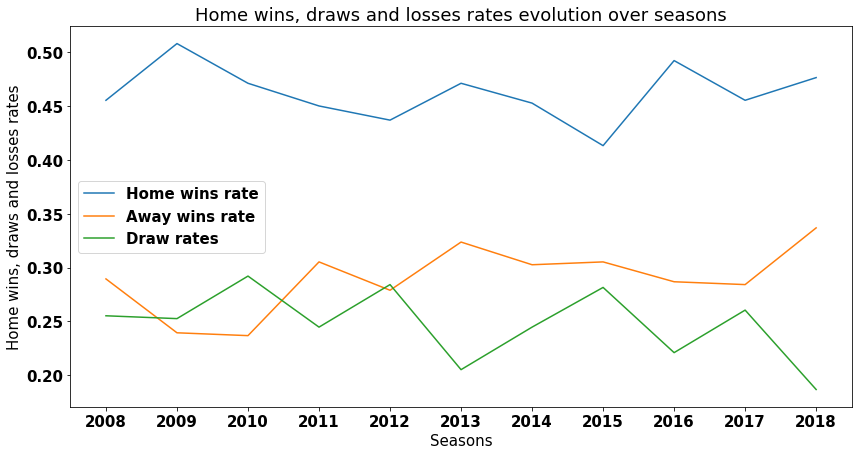

Conclusion : these histograms show a slight correlation between last or 2nd last home/away team results and current next home result. Nevertheless, when this past result (away or home) is a draw, results repartition is significantly close to the global repartition


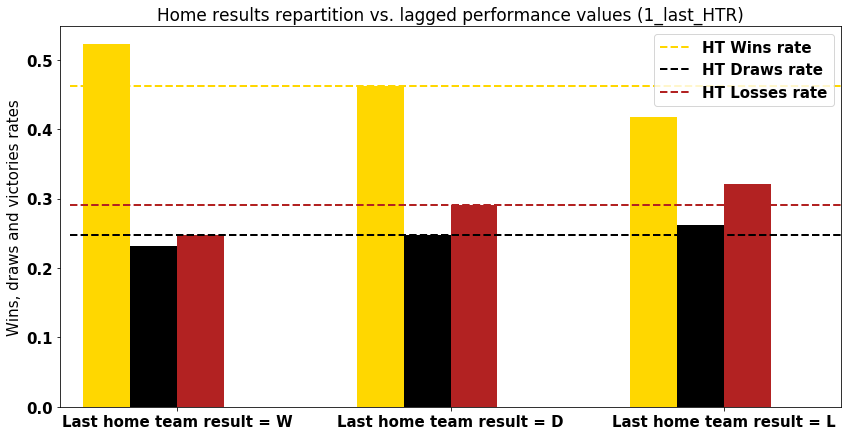

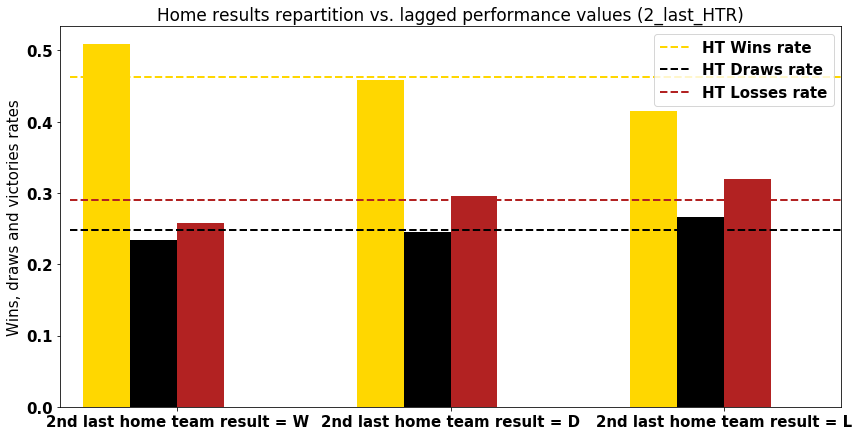

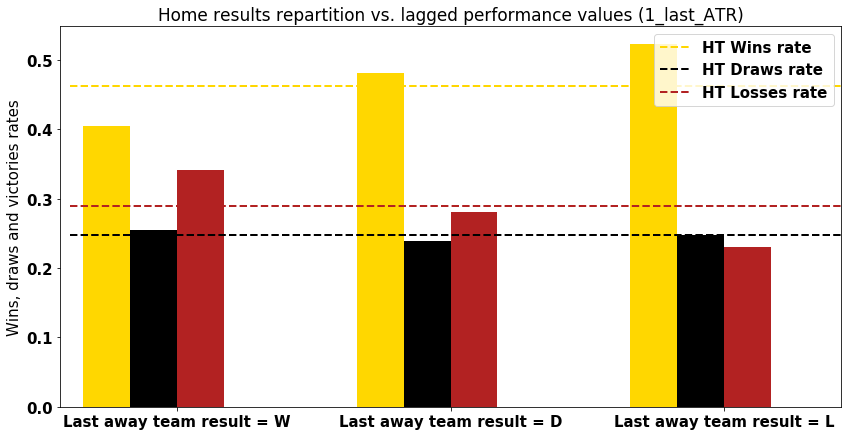

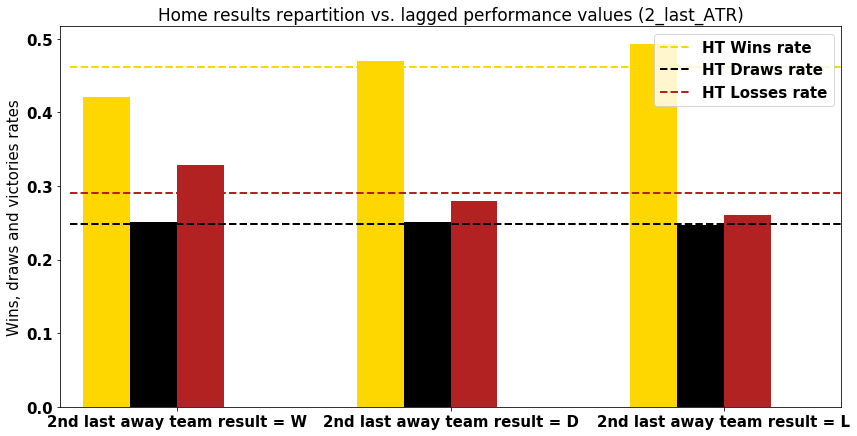

In [49]:
# for analysis and visualisation 
#Home wins, Away wins and draws rates variations over seasons
HW_rates = []
AW_rates = []
D_rates = []

for season in seasons:
    season_data = E0_data[E0_data['Season'] == season]
    total_matches_nb = len(season_data.index)
    HW_rate = float(len(season_data[season_data['FTR'] == 'H'].index))/float(total_matches_nb)
    AW_rate = float(len(season_data[season_data['FTR'] == 'A'].index))/float(total_matches_nb)
    D_rate = float(len(season_data[season_data['FTR'] == 'D'].index))/float(total_matches_nb)
    HW_rates.append(HW_rate)
    AW_rates.append(AW_rate)
    D_rates.append(D_rate)

plt.figure()
plt.plot(seasons, HW_rates, label="Home wins rate")
plt.plot(seasons, AW_rates, label="Away wins rate")
plt.plot(seasons, D_rates, label="Draw rates")
plt.legend()
plt.xticks([int(season) for season in seasons], seasons)
plt.xlabel("Seasons")
plt.ylabel("Home wins, draws and losses rates")
plt.title("Home wins, draws and losses rates evolution over seasons")

plt.show()


#global wins, draws and losses rates
HW_rate = float(len(E0_data[E0_data['HR'] == 'W'].index))/float(len(E0_data.index))
HL_rate = float(len(E0_data[E0_data['HR'] == 'L'].index))/float(len(E0_data.index))
HD_rate = float(len(E0_data[E0_data['HR'] == 'D'].index))/float(len(E0_data.index))
rates = [HW_rate, HL_rate, HD_rate]

width = 0.12
xticks = np.array([0.3, 1.0, 1.7])
xticksLabels = ['0.0 - 0.2', '0.2 - 0.4', '0.4 - 0.6']
xlabels = [["Last home team result = W", "Last home team result = D", "Last home team result = L"],
           ["2nd last home team result = W", "2nd last home team result = D", "2nd last home team result = L"],
           ["Last away team result = W", "Last away team result = D", "Last away team result = L"],
            ["2nd last away team result = W", "2nd last away team result = D", "2nd last away team result = L"]]

var_names = ['1_last_HTR', '2_last_HTR', '1_last_ATR', '2_last_ATR']
titles = ["Home results repartition vs. lagged performance values (" + var_name + ")" for var_name in var_names]

k=0
for var_name in var_names:
    
    fig = plt.figure()
    HW_rates = []
    HD_rates = []
    
    for Rvalue in ['W','D','L']:
        HW_rates.append(len(E0_data[(E0_data[var_name] == Rvalue) & (E0_data['HR'] == 'W')].index) / len(E0_data[E0_data[var_name] == Rvalue].index))
        HD_rates.append(len(E0_data[(E0_data[var_name] == Rvalue) & (E0_data['HR'] == 'D')].index) / len(E0_data[E0_data[var_name] == Rvalue].index))
    
    HL_rates = [1 - (HW_rate + HD_rate) for (HW_rate, HD_rate) in zip(HW_rates, HD_rates)]
    
    plt.bar(xticks - 1.5 * width, HW_rates, width, color = 'gold' )
   
    plt.bar(xticks - 0.5 * width, HD_rates, width, color = 'k')
   
    plt.bar(xticks + 0.5 * width, HL_rates, width, color = 'firebrick')
   
    plt.plot((0.025, 2.0), (HW_rate, HW_rate), '--', color='gold', linewidth=2)
    plt.plot((0.025, 2.0), (HD_rate, HD_rate), '--', color='k', linewidth=2)
    plt.plot((0.025, 2.0), (HL_rate, HL_rate), '--', color='firebrick', linewidth=2)
    
    pylab.xticks(xticks, xlabels[k])
    plt.ylabel("Wins, draws and victories rates")
    plt.legend(["HT Wins rate", "HT Draws rate", "HT Losses rate"])
    plt.xlim(0.0, 2.0)
    plt.title(titles[k], fontsize=17)

    k += 1

print("Conclusion : these histograms show a slight correlation between last or 2nd last home/away team results and current next home result. Nevertheless, when this past result (away or home) is a draw, results repartition is significantly close to the global repartition")



Text(0.5, 1.0, 'Elo score distribution histogram')

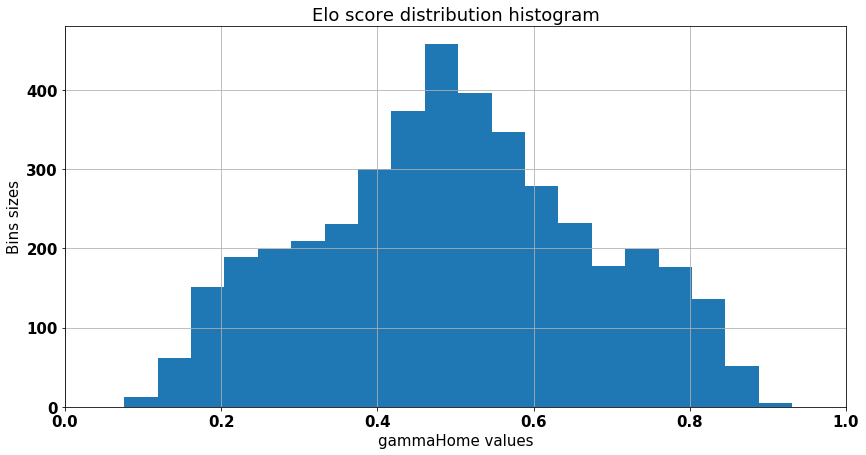

In [50]:
plt.hist(E0_data['gammaHome'].values, bins=20)
plt.xlabel("gammaHome values")
plt.ylabel("Bins sizes")
plt.xlim(0,1)
plt.grid()
plt.title("Elo score distribution histogram")

 : it seems that at least 2 seasons are needed for teams Elo scores to get to their normal values range (2 seasons = 2 * 380 matches).


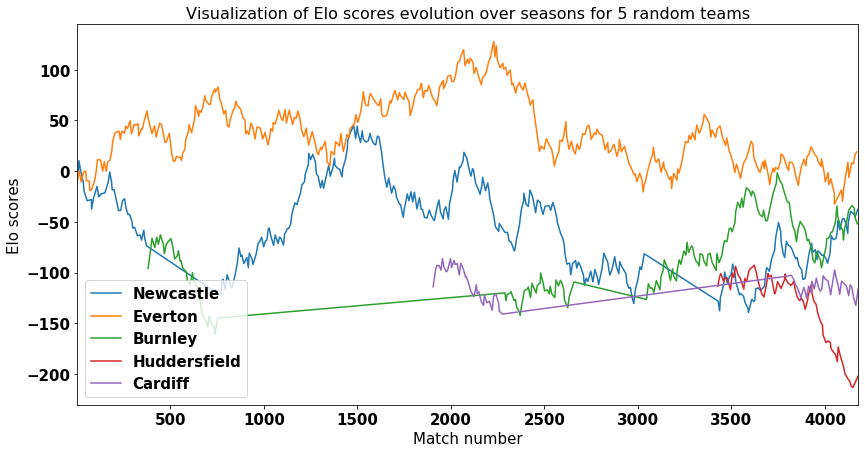

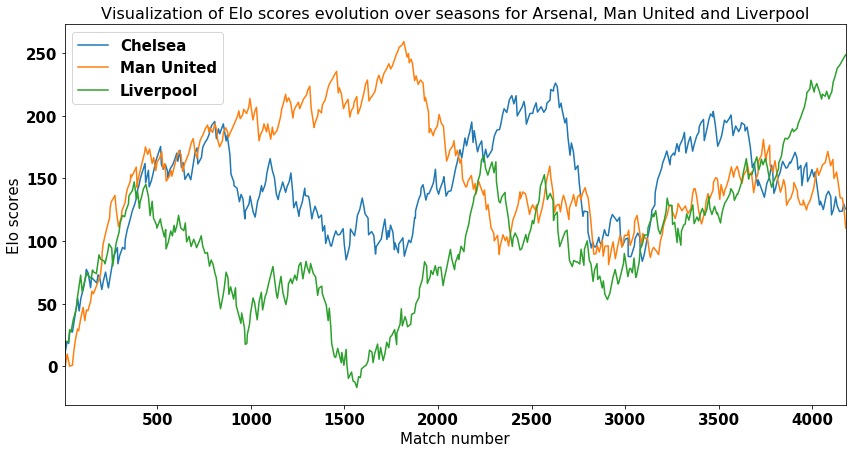

In [51]:
fig = plt.figure()
#random teams elo score visualization
random_teams = [teams[random.randint(0, len(teams))-1] for k in range(0,5)]
for team in random_teams:
    HomeEloScores = E0_data[E0_data['HomeTeam'] == team]['HTeamEloScore']
    AwayEloScores = E0_data[E0_data['AwayTeam'] == team]['ATeamEloScore']
    EloScores = pd.concat([HomeEloScores, AwayEloScores]).sort_index()
    EloScores.plot()
plt.legend(random_teams)
plt.xlabel('Match number')
plt.ylabel('Elo scores')
plt.title('Visualization of Elo scores evolution over seasons for 5 random teams', fontsize = 16)
    
fig = plt.figure()
for team in ['Chelsea', 'Man United', 'Liverpool', ]:
    HomeEloScores = E0_data[E0_data['HomeTeam'] == team]['HTeamEloScore']
    AwayEloScores = E0_data[E0_data['AwayTeam'] == team]['ATeamEloScore']
    EloScores = pd.concat([HomeEloScores, AwayEloScores]).sort_index()
    EloScores.plot()
plt.legend(['Chelsea', 'Man United', 'Liverpool'])
plt.xlabel('Match number')
plt.ylabel('Elo scores')
plt.title('Visualization of Elo scores evolution over seasons for Arsenal, Man United and Liverpool', fontsize=16)

print (" : it seems that at least 2 seasons are needed for teams Elo scores to get to their normal values range (2 seasons = 2 * 380 matches).")

In [52]:
#Create X and Y
X = pd.get_dummies(E0_data[['HomeTeam', 'AwayTeam', 'Season', 'ordinalHR']])
Y = E0_data[['FTR']]

#Split X and Y into training and Test Sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=False)
print("Xtrain shape: ", x_train.shape, "Xtest shape: ", x_test.shape)

#Setup the model
model = LogisticRegression(C=1)

#Train the Model
model.fit(x_train, y_train)

#Coefficient Check
coef = model.coef_[0]
print (coef)

#Model Score
print("Train Score: ", model.score(x_train, y_train))
print("Test Score: ", model.score(x_test, y_test))

Xtrain shape:  (3135, 74) Xtest shape:  (1045, 74)
[ 1.42984835e-03 -1.15453202e+01 -2.92970143e-01  2.82351532e-02
 -1.92075209e-01  5.33181193e-02  8.74428673e-02  1.23265390e-01
  6.63033676e-02  0.00000000e+00  6.62777051e-02  7.91190575e-02
 -3.41380999e-01  3.10411594e-01 -2.05694451e-01  1.25661152e-01
  0.00000000e+00  2.50105125e-01 -1.26446575e-01 -3.41892868e-01
 -1.38968724e-01 -1.06355219e-01 -2.09062546e-02  5.62850052e-02
 -1.00049872e-02  2.32519097e-01  9.92096479e-02 -1.66612425e-02
 -6.84835751e-02 -7.67622376e-02  6.71884705e-02 -7.42147890e-02
 -1.96637824e-01  2.50509803e-02  1.55009442e-01  1.31186538e-01
  8.23475612e-03  2.42935287e-01  3.49515060e-01  3.83057692e-02
 -6.13867479e-02 -1.31187934e-01  1.37477629e-02 -8.01807677e-03
 -1.23909308e-02  0.00000000e+00 -1.07590383e-01 -6.52135246e-02
  4.03029761e-01  5.72588475e-02 -9.50655877e-02 -2.70945325e-01
  0.00000000e+00 -1.88896780e-01  9.65952707e-02  3.70676386e-01
  2.46663427e-01  3.47661003e-01 -6.554

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
